# Total COVID-19 deaths for different countries

Script produced by [Laurent Lessard](https://laurentlessard.com)

---

### Import data from JHU CSSE

In [123]:
import pandas as pd
import matplotlib.pyplot as plt

url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv"
df_raw = pd.read_csv(url)

### Reformat data into convenient form

In [124]:
colnames = df_raw.columns

# aggregate by region
df = df_raw.pivot_table(index='Country/Region',values=colnames[4:],aggfunc=sum)

# make countries columns rather than rows
df = df.T

# make the index a datetime object
df = df.reindex( pd.to_datetime(df.index) )

# sort the dates/times
df.sort_index(inplace=True)

# record the latest date
latest_date = df.index[-1].strftime("%a %b %d, %Y")

### List of countries with at least 50 deaths

In [125]:
countries = df.columns[df.iloc[-1] >= 50]

for (i,c) in enumerate(countries):
    print( c.ljust(20), end=' ')
    if i % 5 == 0:
        print()

Austria              
Belgium              Brazil               Canada               China                Denmark              
Dominican Republic   Ecuador              France               Germany              Indonesia            
Iran                 Iraq                 Ireland              Italy                Japan                
Korea, South         Netherlands          Philippines          Portugal             Romania              
Spain                Sweden               Switzerland          Turkey               US                   
United Kingdom       

### Plot shifted death toll for selected countries

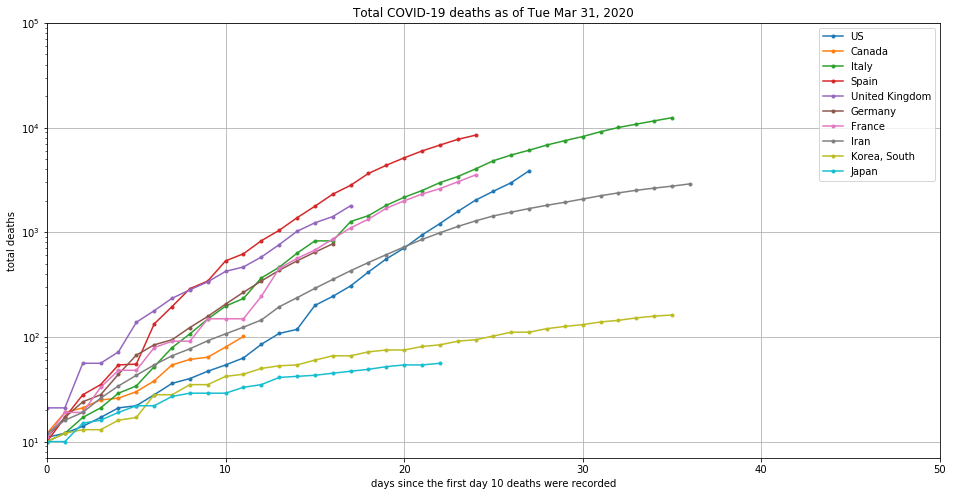

In [126]:
# minimum number of deaths
min_deaths = 10

# selected countries
# countries = ['US','France','Italy','Spain','United Kingdom','Germany','Netherlands','Iran', 'Korea, South', 'Japan']
countries = ['US','Canada','Italy','Spain','United Kingdom','Germany','France','Iran', 'Korea, South', 'Japan']


# shift data so that index corresponds to days since min_death deaths.
shifted_data = []
for (c,data) in df[countries].items():
    shifted_data.append( data[data >= min_deaths].reset_index(drop=True) )

# merge into a single dataframe
dfx = pd.concat( shifted_data, axis=1 )

# make plot
ax = dfx.plot(title="Total COVID-19 deaths as of %s" % latest_date, logy=True, figsize=(16,8), grid=True, marker='.');
ax.set_xlabel("days since the first day %g deaths were recorded" % min_deaths )
ax.set_ylabel("total deaths")
ax.set_ylim(7,1e5)
ax.set_xlim(0,50);
#ax.autoscale(enable=True, axis='x', tight=True)

### Plot deaths in the past week versus total deaths

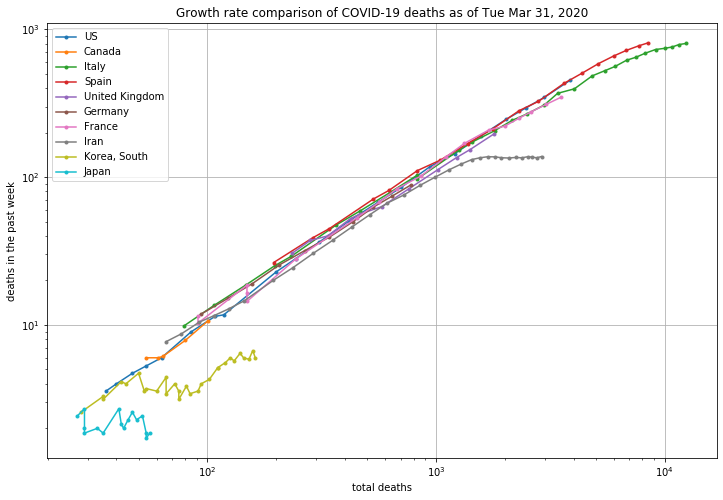

In [127]:
plt.figure(figsize=(12,8))

for data in shifted_data:
    plt.loglog( data, data.diff().rolling(7).mean(), marker=".", label=data.name )
    
plt.xlabel("total deaths")
plt.ylabel("deaths in the past week")
plt.grid()
plt.title("Growth rate comparison of COVID-19 deaths as of %s" % latest_date)
plt.legend();